<style>
/* Inline CSS zum Ändern der Schriftgröße in Jupyter Notebook */
body {
    font-size: 16px; /* Standardtextgröße */
}

h1 {
    font-size: 28px; /* Überschrift 1 Größe */
}

h2 {
    font-size: 24px; /* Überschrift 2 Größe */
}

h3 {
    font-size: 20px; /* Überschrift 3 Größe */
}
</style>

# What causes lung cancer?
The Dataset originated from [Kaggle](https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer?resource=download)

Based on data of 309 individuals the aim is to find correlation and causes for lung cancer. The following features are included in the data set:
- gender
- age
- smoking
- yellow_fingers
- anxiety
- peer_pressure
- chronic disease
- fatigue
- allergy
- wheezing
- alcohol consuming
- coughing
- shortness of breath
- swallowing difficulty
- chest pain

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np

import scipy.stats as stats

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,GridSearchCV

In [2]:
import warnings
# Deactivate Warnings for 'FutureWarning' Klasse
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set option 'use_inf_as_na' to False
pd.set_option('use_inf_as_na', False)

## Data Analysis
### Preparation of dataframe
Load zip file and save data in DataFrame. Rename columns. 

In [3]:
# Path to the zip file
zip_file_path = 'lung_cancer_kaggle.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data_lung_cancer')  # Extract the contents to a folder

# Load the data from the extracted files using pandas
data = pd.read_csv('data_lung_cancer/survey lung cancer.csv')  # Replace 'your_data_file.csv' with the actual file name
#rename columns to lower case

new_cols = ['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety',
       'peer_pressure', 'chronic_disease', 'fatigue', 'allergy', 'wheezing',
       'alcohol_consuming', 'coughing', 'shortness_of_breath',
       'swallowing_difficulty', 'chest_pain', 'lung_cancer']
data.columns = new_cols
display(data.head())


,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


Make a label_encoder function for easy label encoding. Then replace "M" and "F" in gender column with 0 and 1, and "NO" and "YES" in lung_cancer column to 0 and 1.
For more consistency also change 1 and 2 in the rest of the columns to 0 and 1. 
Now, 1 stands for the symptom occurs.

In [4]:
def label_encoder(first, second, first_sub, second_sub, col_name, df):
    """
    Converts two values in a column of a dataframe into two different values for label encoding.
    
    first, second, first_sub, second_sub (str, int, float): Given values and values to substitute with

    return (dataframe): returns altered dataframe
    """
    df[col_name] = df[col_name].replace({first: first_sub})
    df[col_name] = df[col_name].replace({second: second_sub})
    
    
    return df
    

In [5]:
#encode 0 = M, 1 = F
label_encoder("M", "F", 0,1, "gender", data)
#encode 1 to 0, and 2 to 1 for consistency
for col_name in [cols for cols in list(data.columns) if cols not in ["gender", "age", "lung_cancer"]]:
    label_encoder(1,2,0,1,col_name, data)
#encode NO to 0, YES to 1
label_encoder("NO", "YES", 0,1, "lung_cancer", data)

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
0,0,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,0,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,1,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,0,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,1,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,1,56,0,0,0,1,1,1,0,0,1,1,1,1,0,1
305,0,70,1,0,0,0,0,1,1,1,1,1,1,0,1,1
306,0,58,1,0,0,0,0,0,1,1,1,1,0,0,1,1
307,0,67,1,0,1,0,0,1,1,0,1,1,1,0,1,1


### EDA
Check dataset for plausible values, missing values and data types. Find duplicates and remove duplicates. 
Check for correlations and get an overview of dataset.

In [6]:
data.describe()
#plausible min and max values

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.475728,62.673139,0.563107,0.569579,0.498382,0.501618,0.504854,0.673139,0.556634,0.556634,0.556634,0.579288,0.640777,0.469256,0.556634,0.873786
std,0.500221,8.210301,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588,0.332629
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,62.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,87.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
data.info()
#no missing values
#correct data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   gender                 309 non-null    int64
 1   age                    309 non-null    int64
 2   smoking                309 non-null    int64
 3   yellow_fingers         309 non-null    int64
 4   anxiety                309 non-null    int64
 5   peer_pressure          309 non-null    int64
 6   chronic_disease        309 non-null    int64
 7   fatigue                309 non-null    int64
 8   allergy                309 non-null    int64
 9   wheezing               309 non-null    int64
 10  alcohol_consuming      309 non-null    int64
 11  coughing               309 non-null    int64
 12  shortness_of_breath    309 non-null    int64
 13  swallowing_difficulty  309 non-null    int64
 14  chest_pain             309 non-null    int64
 15  lung_cancer            309 non-null    i

In [8]:
print(data.duplicated().sum())
data.drop_duplicates(inplace = True)
print(data.duplicated().sum())
data = data.reset_index(drop = True)

33
0


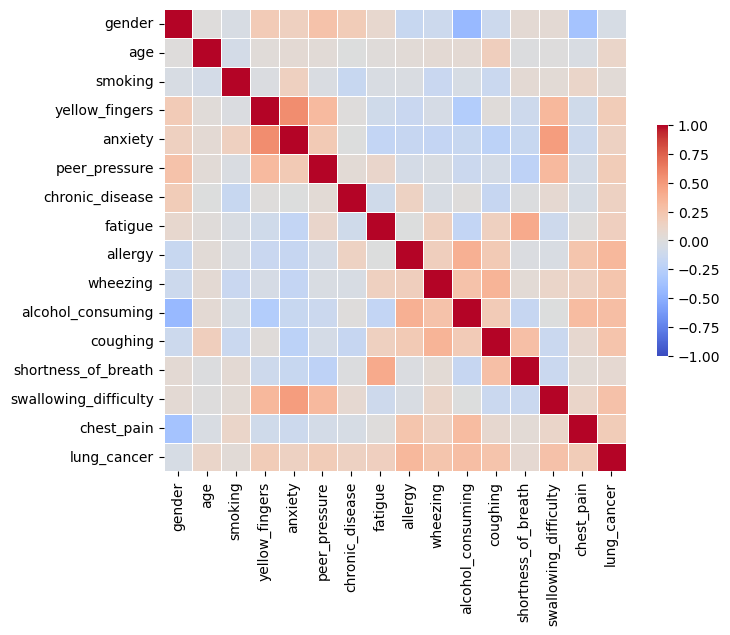

In [9]:
# Compute the correlation matrix
corr = data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin =-1, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

#Note: Important to know would be, how long and how much they have been smoking

### Graphical analysis of the dataset

Text(0.5, -0.3, 'Over 80% of the data refer to cancer patients. Non-cancer data is under-represented.')

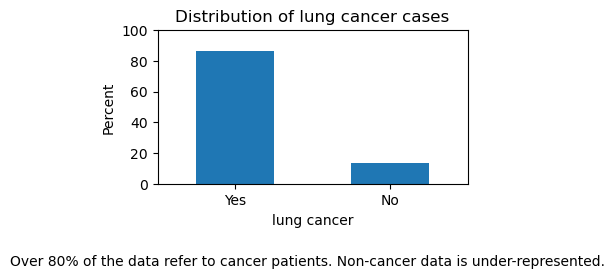

In [10]:
#generate temp. data and leave original df untouched. Replace binary label to Yes and No for nice graph
temp_series = data["lung_cancer"].replace({0: 'No', 1: 'Yes'}) 

column_name = "lung cancer"
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(4, 2))  # Increase width to make room for the note

# Create a bar plot for the current column
temp_series_count = temp_series.value_counts(normalize=True)*100
temp_series_count.plot(kind='bar', ax=ax)

ax.set_title(f'Distribution of {column_name} cases')
ax.set_ylabel('Percent')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel(column_name)
note = "Over 80% of the data refer to cancer patients. Non-cancer data is under-represented."
# Add note below the plot
fig.text(0.5, -0.3, note, ha='center', fontsize=10)

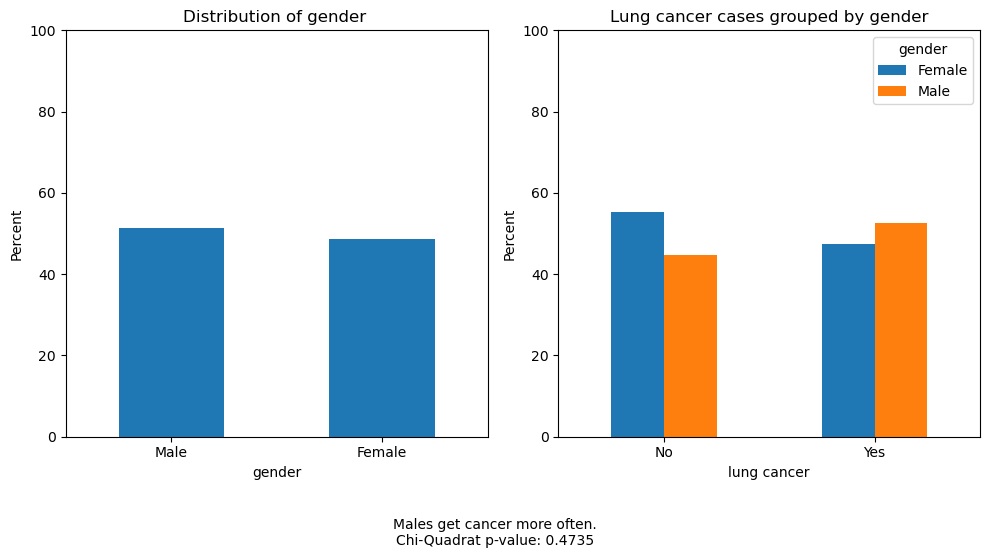

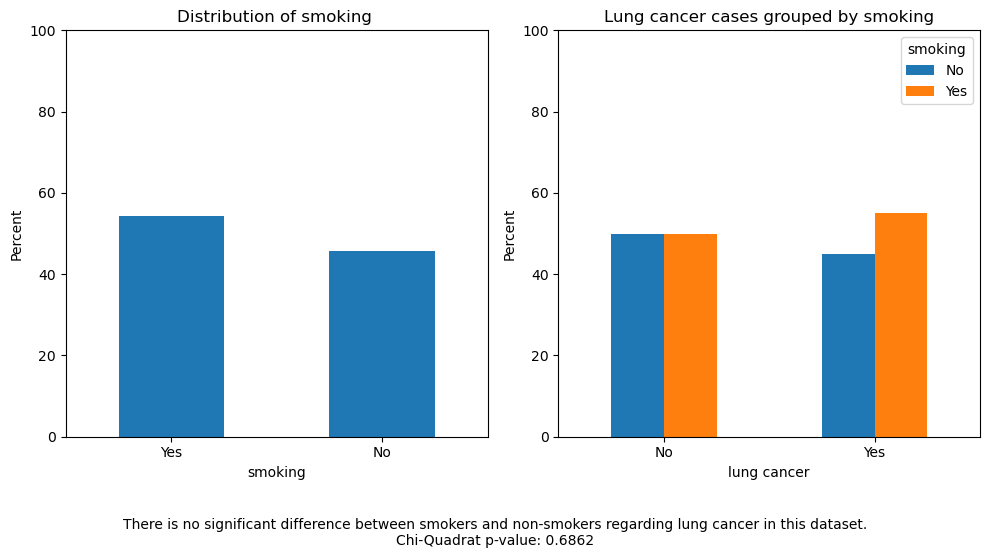

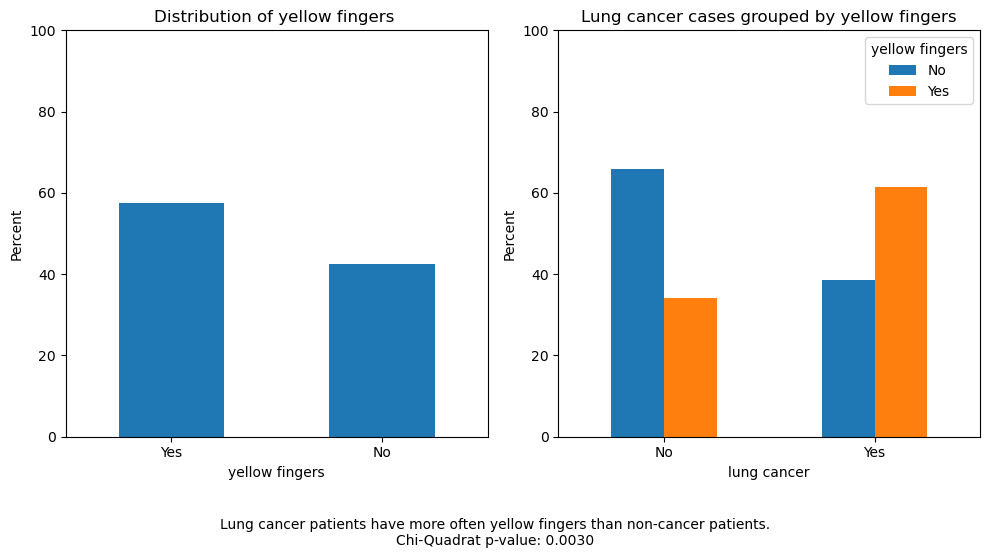

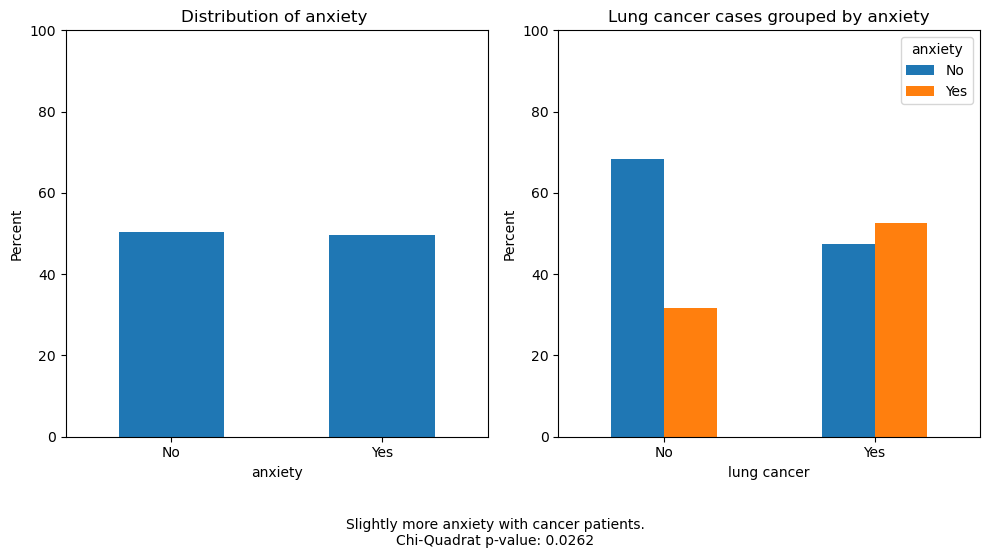

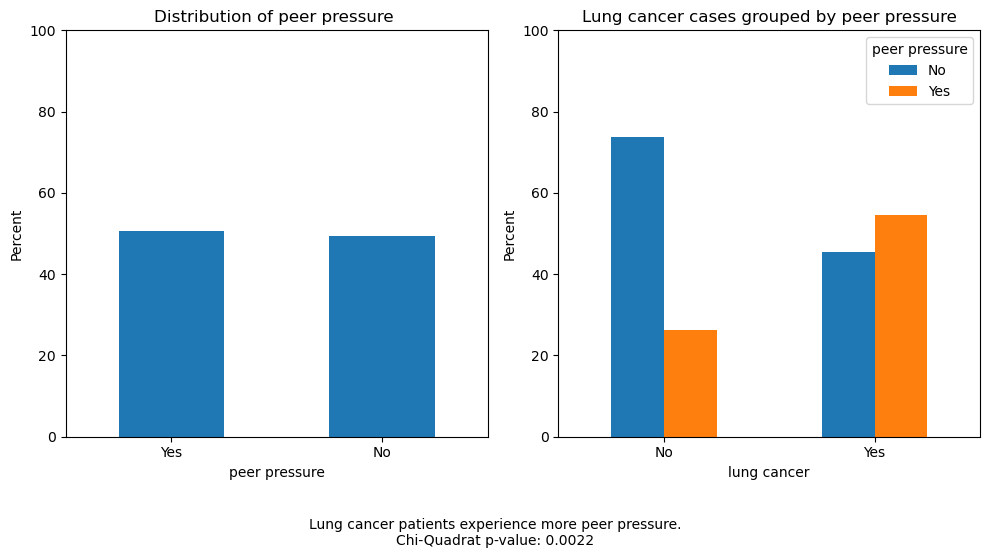

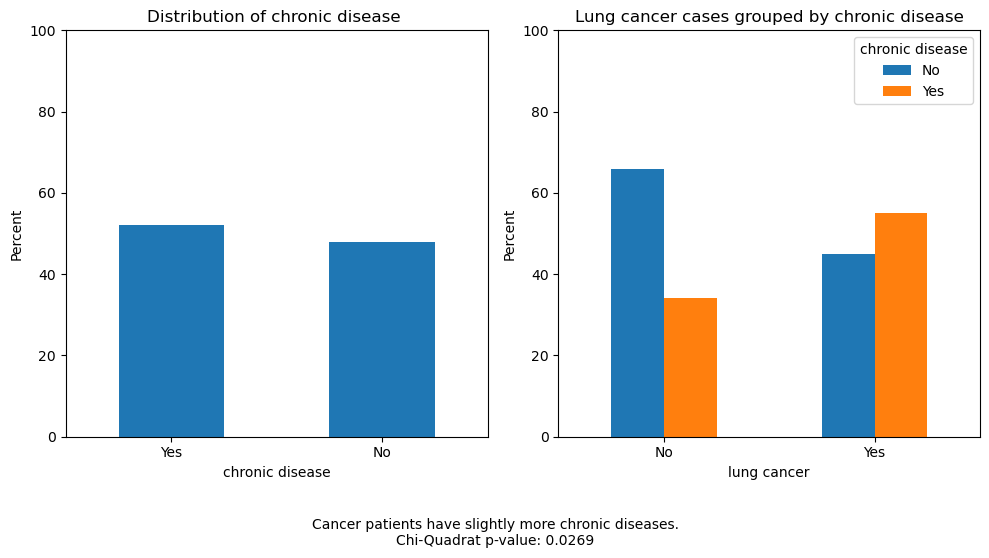

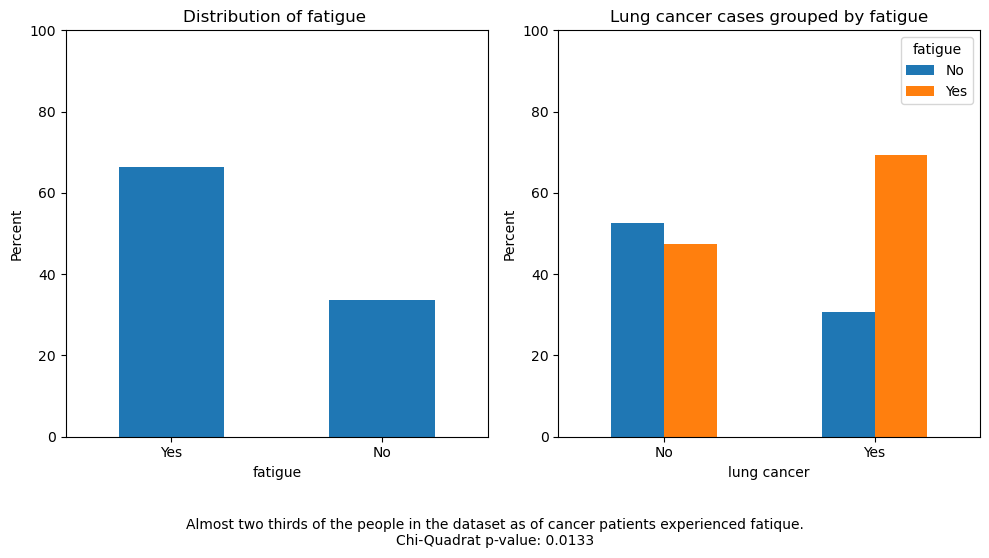

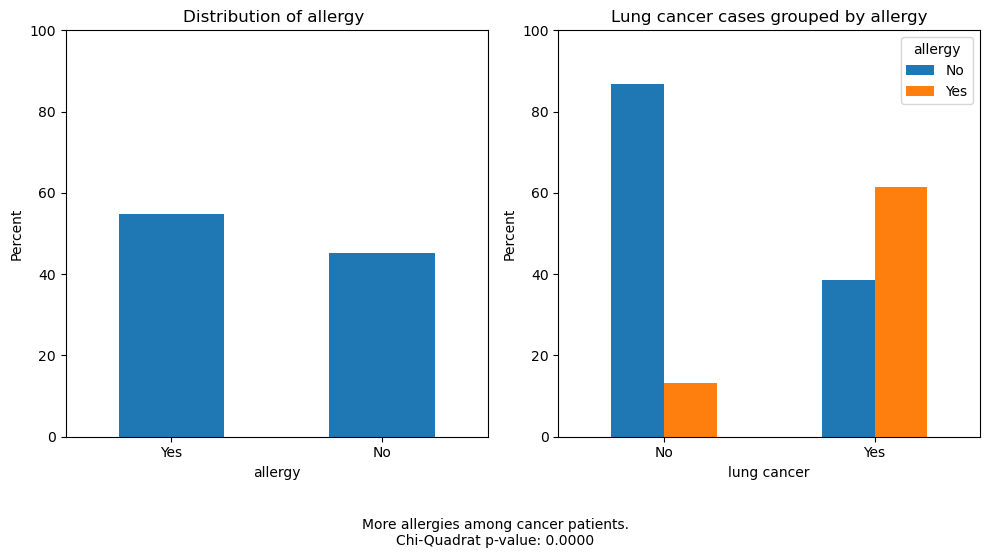

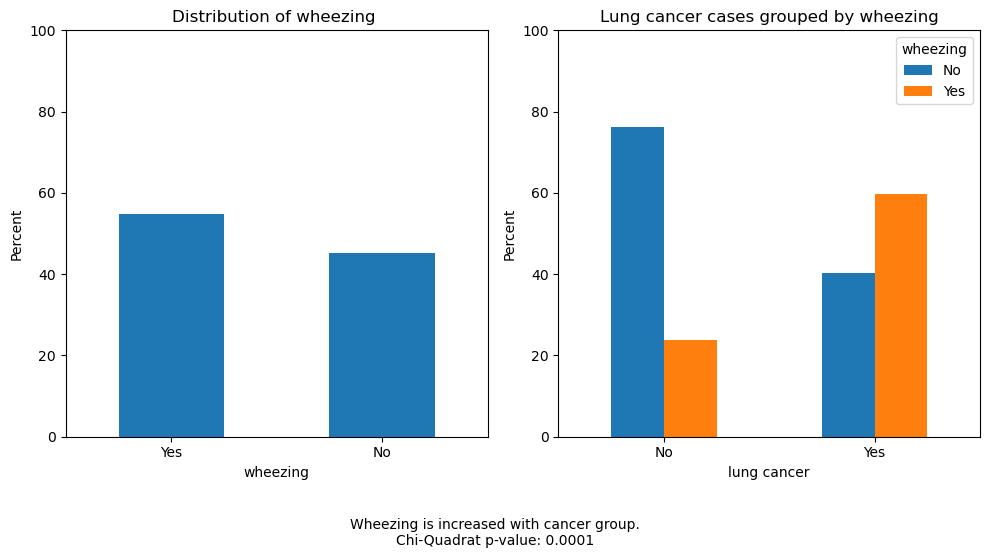

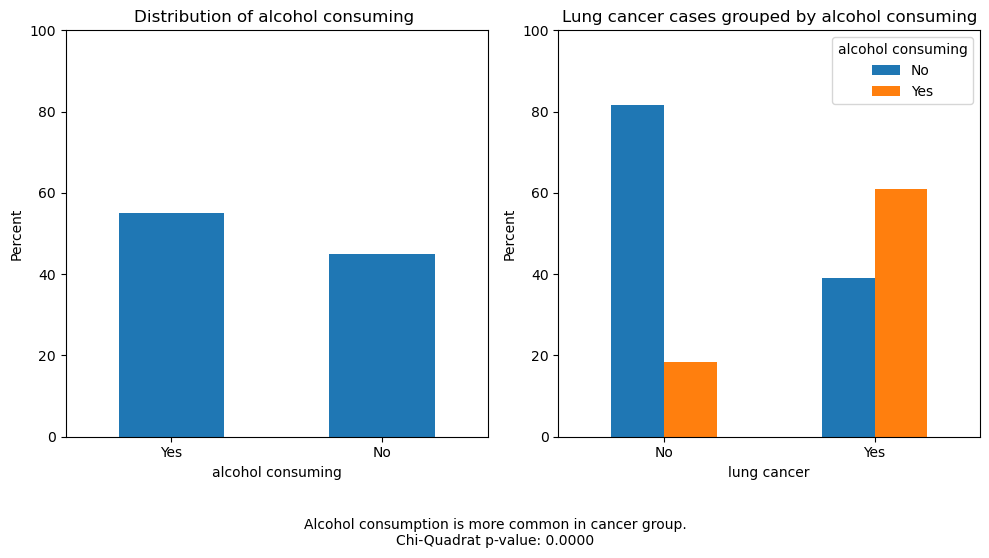

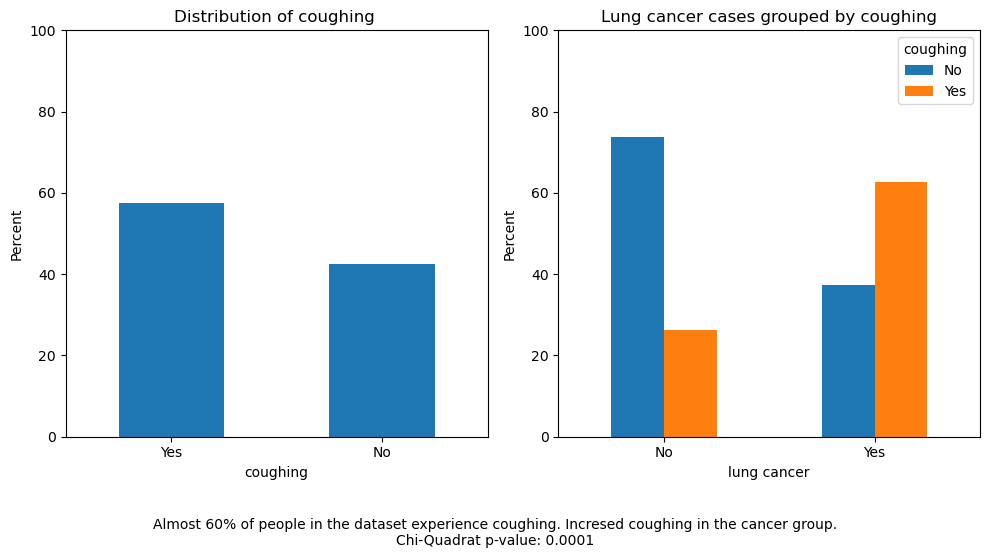

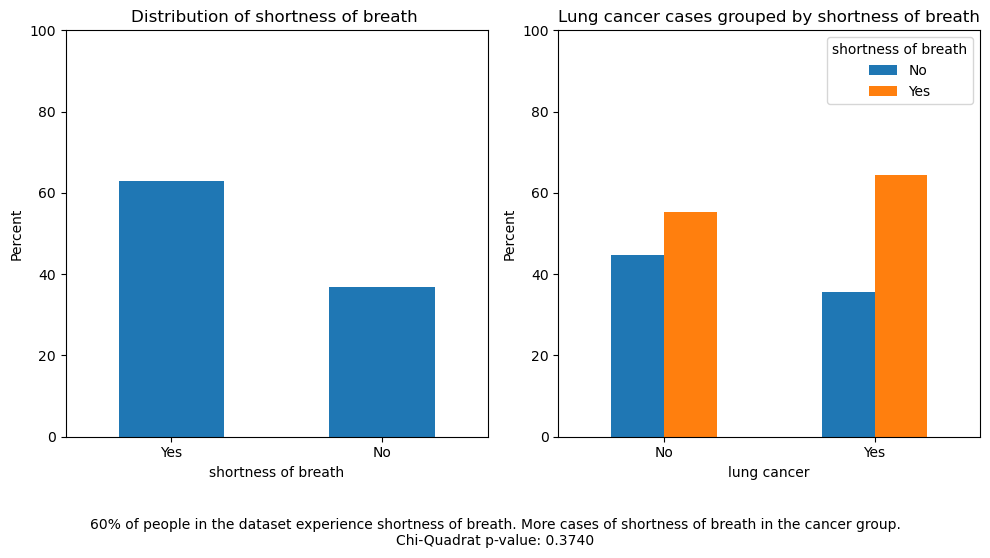

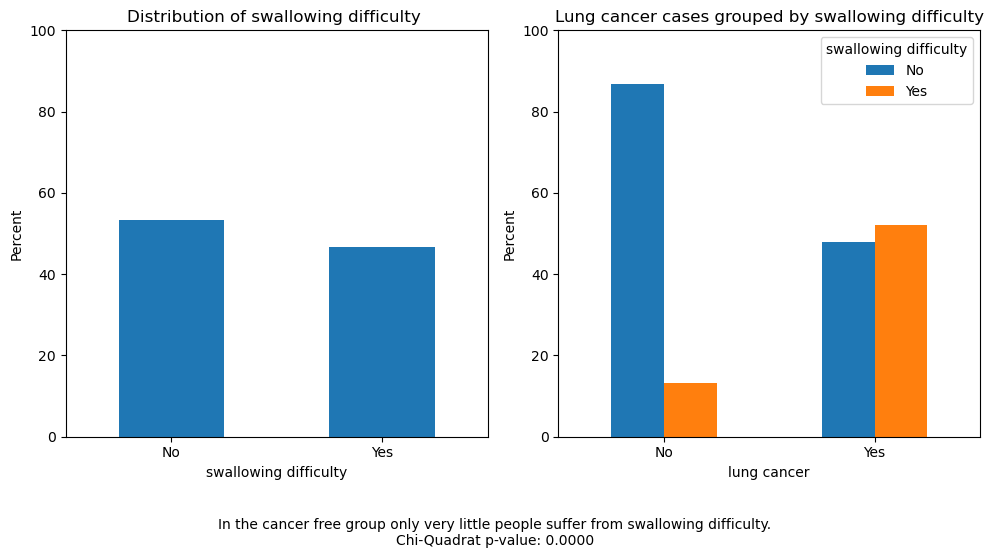

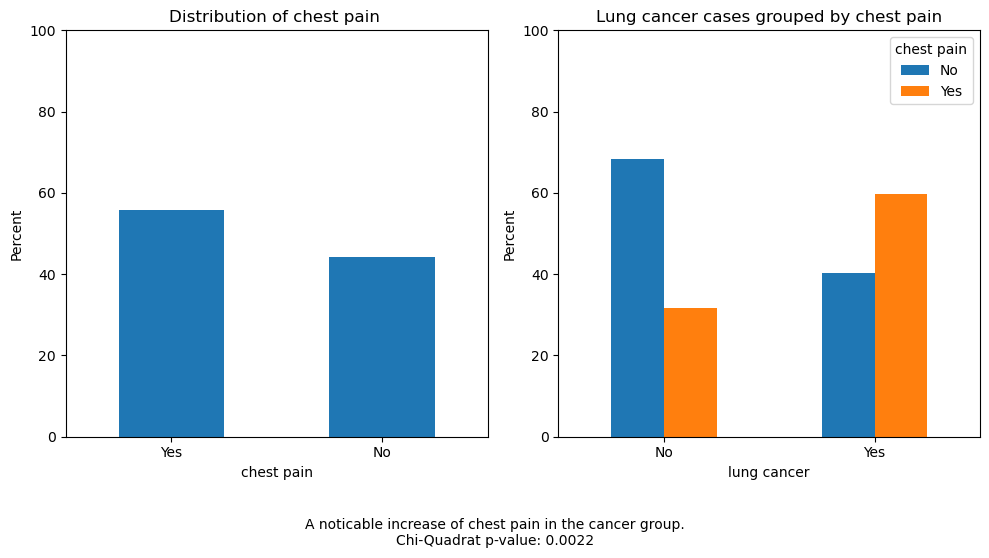

In [11]:
notes = [
    "Males get cancer more often.\n",
    "Placeholder",
    "There is no significant difference between smokers and non-smokers regarding lung cancer in this dataset.\n",
    "Lung cancer patients have more often yellow fingers than non-cancer patients.\n",
    "Slightly more anxiety with cancer patients.\n",
    "Lung cancer patients experience more peer pressure.\n",
    "Cancer patients have slightly more chronic diseases.\n",
    "Almost two thirds of the people in the dataset as of cancer patients experienced fatique.\n", 
    "More allergies among cancer patients.\n",
    "Wheezing is increased with cancer group.\n",
    "Alcohol consumption is more common in cancer group.\n",
    "Almost 60% of people in the dataset experience coughing. Incresed coughing in the cancer group.\n",
    "60% of people in the dataset experience shortness of breath. More cases of shortness of breath in the cancer group.\n",
    "In the cancer free group only very little people suffer from swallowing difficulty.\n",
    "A noticable increase of chest pain in the cancer group.\n"]

chi_test = {}

# Iterate through the columns and the corresponding notes
for i, column in enumerate(data.columns):
    if column != "age" and column != "lung_cancer":
        if column == "gender":
            temp_series = data[column].replace({0: 'Male', 1: 'Female'})
        else:
            temp_series = data[column].replace({0: 'No', 1: 'Yes'})
        
        column_name = column.replace("_" , " ")
        
        # Chi-Quadrat-Test
        temp_data = data["lung_cancer"].replace({0: 'No', 1: 'Yes'})
        contingency_table = pd.crosstab(temp_data, temp_series)
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        chi_test[column] = p
        
        # Create a figure and a set of subplots
        fig, ax = plt.subplots(figsize=(10, 5), ncols=2)  # Increase width to make room for the note
        
        # Create a bar plot for the current column
        temp_series_count = temp_series.value_counts(normalize=True) * 100
        temp_series_count.plot(kind='bar', ax=ax[0])
        
        ax[0].set_title(f'Distribution of {column_name} ')
        ax[0].set_ylabel('Percent')
        ax[0].set_ylim(0, 100)
        ax[0].tick_params(axis='x', rotation=0)
        ax[0].set_xlabel(column_name)

        temp_series_ct = pd.crosstab(index=temp_data, columns=temp_series, normalize='index') * 100
        temp_series_ct.plot(kind="bar", ax=ax[1])
        
        ax[1].set_title(f'Lung cancer cases grouped by {column_name}')
        ax[1].set_ylabel('Percent')
        ax[1].set_ylim(0, 100)
        ax[1].tick_params(axis='x', rotation=0)
        ax[1].set_xlabel("lung cancer")

        # Update the legend to include the column name in the legend labels
        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(title=column_name)
        
        # Add note and p-value below the plot
        fig.text(0.5, -0.1, notes[i] + f'Chi-Quadrat p-value: {p:.4f}', ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()




The most significant symptoms regarding lung cancer are according to the chi² test allergy, alcohol consumption and swallowing difficulty. Those are also the symptoms which are more abundand in cancer patients.


In [12]:
sorted_by_values = dict(sorted(chi_test.items(), key=lambda item: item[1]))
print("p-values of Chi² test")
sorted_by_values


p-values of Chi² test


{'allergy': 8.05429205334748e-08,
 'alcohol_consuming': 2.4086991438876807e-06,
 'swallowing_difficulty': 1.7635190206742663e-05,
 'coughing': 5.6529389924273907e-05,
 'wheezing': 7.428545731084955e-05,
 'peer_pressure': 0.0021672427038890037,
 'chest_pain': 0.0022037245782825345,
 'yellow_fingers': 0.0030136445827510243,
 'fatigue': 0.013337652970972067,
 'anxiety': 0.026218689238431004,
 'chronic_disease': 0.026943736855531426,
 'shortness_of_breath': 0.3739728404282008,
 'gender': 0.4735014562057904,
 'smoking': 0.6861517524363567}

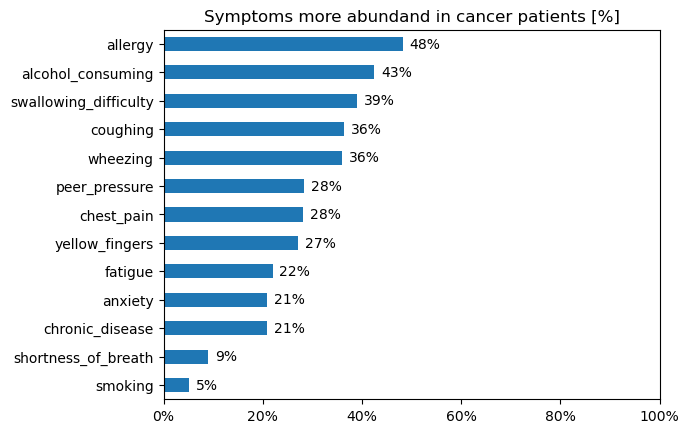

In [13]:
#devide data set in cancer and cancer free datapoints
data_lung_cancer_positive = data[data["lung_cancer"] ==1]
data_lung_cancer_negative = data[data["lung_cancer"] ==0]

#compute mean differences
cancer_to_no_cancer = data_lung_cancer_positive.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] - data_lung_cancer_negative.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"]
cancer_to_no_cancer = cancer_to_no_cancer.sort_values(ascending=True)

bars = cancer_to_no_cancer.plot(kind="barh", xlim=(0,1))
plt.title("Symptoms more abundand in cancer patients [%]")

for bar in bars.patches:
    plt.annotate(f'{bar.get_width():.0%}',                            
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),  
                 xytext=(5, 0),                                       
                 textcoords='offset points',
                 ha='left', va='center',                              
                 fontsize=10, color='black')

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1)) 



Text(0.5, -0.1, 'For some ages only non-cancer data is available.')

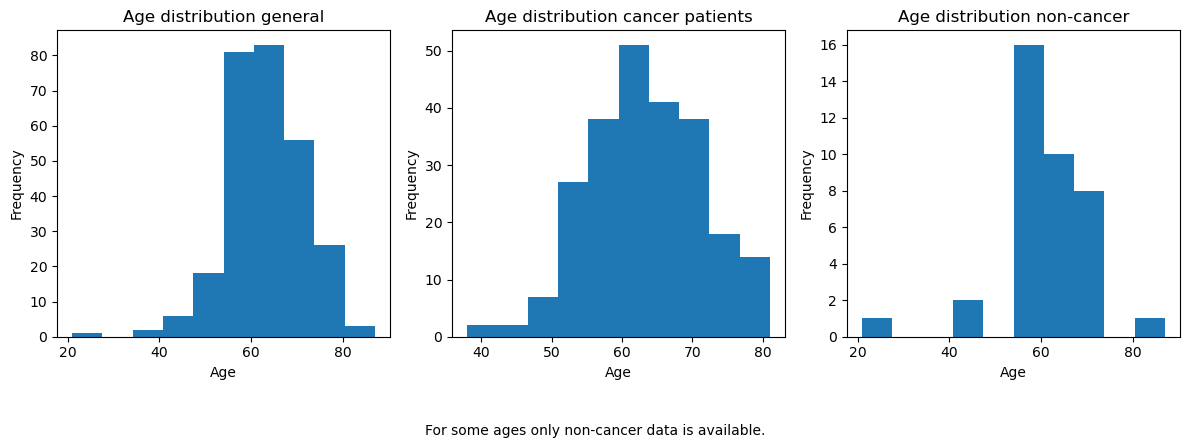

In [14]:
mask_cancer = data["lung_cancer"] == 1
mask_nocancer = data["lung_cancer"] == 0

fig, ax = plt.subplots(figsize=(12,4), ncols = 3)
data["age"].plot(kind='hist', ax=ax[0])
data[mask_cancer]["age"].plot(kind="hist", ax=ax[1])
data[mask_nocancer]["age"].plot(kind="hist", ax=ax[2])

ax[0].set_title("Age distribution general")
ax[1].set_title("Age distribution cancer patients")
ax[2].set_title("Age distribution non-cancer")

for i in [0,1,2]:
    ax[i].set_xlabel("Age")

plt.tight_layout()
note = "For some ages only non-cancer data is available."
# Add note below the plot
fig.text(0.5, -0.1, note, ha='center', fontsize=10)

### Summary Data Analysis

The cancer-free group is underrepresented. 
Nevertheless, some correlations with lung cancer are recognizable. 

**Allergies, alcohol consumption and difficulty swallowing** appear to be the symptoms and facts most strongly associated with lung cancer. 
Interestingly, there are no significant differences between smokers and non-smokers with regard to lung cancer. However, the data does not distinguish between current and former smokers. Non-smokers who developed lung cancer could therefore have smoked for decades.


## Data Science - Machine Learning

### Split Dataset to Train and Test Data

In [15]:
from sklearn.model_selection import train_test_split

# Define features and target
features = data.drop('lung_cancer', axis=1)  
target = data['lung_cancer']  

# Split in Train and Test Data
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)
for df in [features_train, features_test, target_train, target_test]:
    print(df.shape)

(193, 15)
(83, 15)
(193,)
(83,)


### SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address class imbalance in datasets. It generates synthetic examples for the minority class by interpolating between existing samples. This helps to balance the class distribution and improve model performance on imbalanced data.

In [16]:
#less cancer-free datapoints than cancer datapoints
pd.crosstab(index=target_train, columns="count")

col_0,count
lung_cancer,
0,25
1,168


In [17]:
#Artificial enlargement of the minority category “no lung cancer”
smotesampler = SMOTE(random_state=42)
features_smote, target_smote = smotesampler.fit_resample(features_train, target_train)
pd.crosstab(index=target_smote, columns="count")

col_0,count
lung_cancer,
0,168
1,168


### Feature Engineering and One Hot Encoding (only train set)
Generate age groups to see if lung cancer correlates with a certain age group. 

<Axes: xlabel='age'>

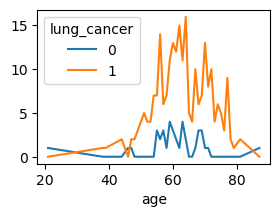

In [18]:
pd.crosstab(index=data["age"], columns=data["lung_cancer"]).plot(figsize=(3,2))
#very little datapoints below 45
#cut main points between 45 and 75 in two groups

In [19]:
def feature_engineering(features):
    """
    Performs feature engineering on the provided DataFrame, including grouping age ranges 
    and applying One-Hot-Encoding to the age group.

    Parameters:
    features (DataFrame): The input data as a Pandas DataFrame. 
                          It should contain an 'age' column and any other feature columns.

    Returns:
    DataFrame: A transformed DataFrame with age groups one-hot encoded and 
               other features remaining unchanged.
    """
    # Group people in 'under 45', 'ages 45-59', 'ages 60-74', '75+'
    mask_under_45 = features["age"] < 45
    mask_45_60 = (features["age"] >= 45) & (features["age"] < 60)
    mask_60_75 = (features["age"] >= 60) & (features["age"] < 75)
    mask_over_75 = features["age"] >= 75

    conditions = [mask_under_45, mask_45_60, mask_60_75, mask_over_75]
    values = ['under 45', 'ages 45-59', 'ages 60-74', '75+']

    features['age_group'] = np.select(conditions, values, default='Unknown')

    # Initialize OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False)

    # Initialize ColumnTransformer
    columns = ['age_group']
    encoder = ColumnTransformer([("OHE", ohe, columns)], remainder="passthrough")

    # Fit encoder to the features data
    encoder.fit(features)

    # Get feature names for one-hot encoded features
    ohe_names = encoder.named_transformers_["OHE"].get_feature_names_out(columns)
    # Get names of remaining features
    remaining_names = [name for name in features.columns if name not in columns]

    # Combine new column names
    all_names = list(ohe_names) + remaining_names

    # Transform the features data
    features_transformed = encoder.transform(features)

    # Create a DataFrame with the new column names
    features_ohe = pd.DataFrame(features_transformed, columns=all_names)

    return features_ohe


In [20]:
#apply feature_engineering function
features_train_ohe = feature_engineering(features_train)
print("Biggest group are people between age 60 and 74. Only 2 people are under 40.")
features_train["age_group"].value_counts()

Biggest group are people between age 60 and 74. Only 2 people are under 40.


age_group
ages 60-74    113
ages 45-59     62
75+            16
under 45        2
Name: count, dtype: int64

### Metrics for model evaluation
We aim to predict cancer, where failing to identify cancer is more critical than incorrectly predicting cancer in a healthy patient. While a false positive may cause emotional distress to the patient, the consequences of missing a cancer diagnosis can be far more severe. In this context, a high Recall is essential. However, asserting that all patients have cancer is also problematic. Therefore, Precision must also be considered, though it may be weighted less heavily compared to Recall. 

In [21]:
def eval_regression(model, features, target):
    """
    Evaluates the trained regression model based on the metrics Accuracy, 
    Precision, Recall and F1 Score

    model (ML model)
    features (df): Features of the test data correspond to those used during training
    target (Series): target of test data

    Returns nothing.
    
    """
    
    target_test_pred = model.predict(features)
    precision = precision_score(target, target_test_pred)
    recall = recall_score(target, target_test_pred)
    accuracy = accuracy_score(target, target_test_pred)
    f1 = f1_score(target, target_test_pred)
    print(f'Precision Score: {precision:.4f}')
    print(f'Recall Score: {recall:.4f}')
    print(f'Accuracy Score: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')

    cm = confusion_matrix(target, target_test_pred)
    
    # Define labels
    labels = ['Negative', 'Positive']
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    
    # Add titles and labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Show the plot
    plt.show()

    return None

### Machine Learning Models

#### Descision Tree 

In [22]:
# Define model
model = DecisionTreeClassifier(max_depth=4, random_state=42)

# Define hyperparameter search grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# train modell 
grid_search.fit(features_train_ohe, target_train)

# Best Parameter and Accuracy
print("Best Parameter:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameter: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best Accuracy: 0.8759784075573549


Precision Score: 0.8933
Recall Score: 0.9571
Accuracy Score: 0.8675
F1 Score: 0.9241


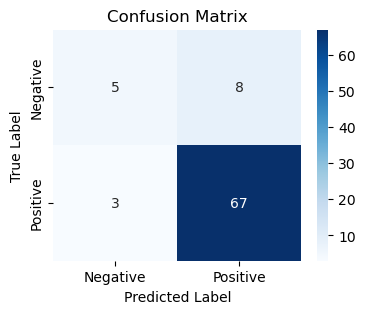

In [23]:
best_model = grid_search.best_estimator_

#Test model on test data set
#Generate age groups and OHE them
features_test_ohe = feature_engineering(features_test)

#Evaluate the model
eval_tree = eval_regression(best_model, features_test_ohe, target_test)
eval_tree

#### Descision Tree Evaluation
The model reaches an accuracy of 0.88 on training data. The Recall score of 0.96 is good. But the model fails to predict non-cancer cases. 

#### Logistic Regression
To select the features for the logistic regression we have a look at the abundance of symptoms in cancer patients and non-cancer patients **after** SMOTE.

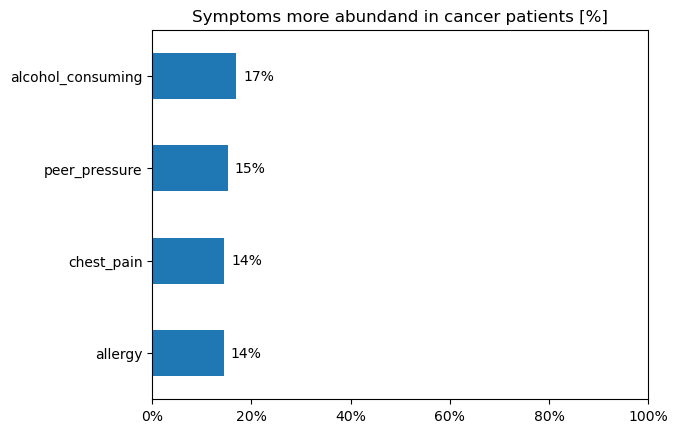

In [24]:
#Generate complete dataset of features and target after SMOTE
features_and_target_train = features_train_ohe.copy()
features_and_target_train["lung_cancer"] = target_train 
#Split dataset in datapoints with and without cancer
data_lung_cancer_positive = features_and_target_train[features_and_target_train["lung_cancer"] ==1] 
data_lung_cancer_negative = features_and_target_train[features_and_target_train["lung_cancer"] ==0] 

#mean differences of cancer group
cancer_to_no_cancer = data_lung_cancer_positive.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] - data_lung_cancer_negative.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"]
cancer_to_no_cancer = cancer_to_no_cancer.sort_values(ascending = False).head(4)
cancer_to_no_cancer = cancer_to_no_cancer.sort_values(ascending = True)
bars = cancer_to_no_cancer.plot(kind="barh", xlim=(0,1))

plt.title("Symptoms more abundand in cancer patients [%]")

for bar in bars.patches:
    plt.annotate(f'{bar.get_width():.0%}',                            
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),  
                 xytext=(5, 0),                                       
                 textcoords='offset points',
                 ha='left', va='center',                              
                 fontsize=10, color='black')

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1)) 





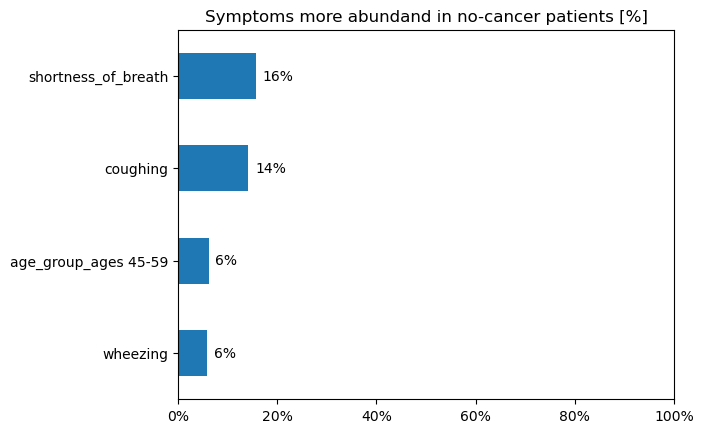

In [25]:
#symptoms more abundand in the no cancer group SMOTE dataset
cancer_to_no_cancer_reverse = data_lung_cancer_negative.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] - data_lung_cancer_positive.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] 
cancer_to_no_cancer_reverse = cancer_to_no_cancer_reverse.sort_values(ascending = False).head(4)
cancer_to_no_cancer_reverse = cancer_to_no_cancer_reverse.sort_values(ascending = True)
bars = cancer_to_no_cancer_reverse.plot(kind="barh", xlim=(0,1))
plt.title("Symptoms more abundand in no-cancer patients [%]")

for bar in bars.patches:
    plt.annotate(f'{bar.get_width():.0%}',                            
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),  
                 xytext=(5, 0),                                       
                 textcoords='offset points',
                 ha='left', va='center',                              
                 fontsize=10, color='black')

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1)) 

In [26]:
#Generate age groups and OHE
features_test_ohe = feature_engineering(features_test)


CrossValScore:  0.8963562753036438
Precision Score: 0.9200
Recall Score: 0.9857
Accuracy Score: 0.9157
F1 Score: 0.9517


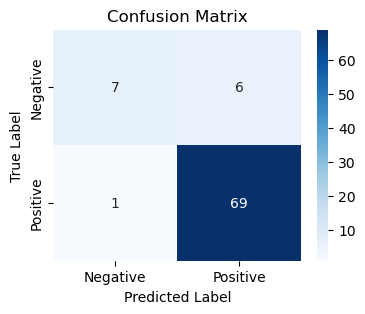

In [27]:
#Train logistic regression model: begin with top 4 symptoms in cancer patients (after SMOTE)
#features for training
feature_list = ["alcohol_consuming",
                "peer_pressure",
                "chest_pain",
                "allergy"
                ] 

features_train_log = features_train_ohe.loc[:,feature_list]
model_log = LogisticRegression(solver = "lbfgs", max_iter=1000, C=4, random_state=42) 
model_log.fit(features_train_log, target_train)

#Crossvalidation to for more reliable estimate of model's performance
cv_logrreg = cross_val_score(model_log, features_train_log, target_train, scoring="accuracy", cv=5)
print("CrossValScore: " ,cv_logrreg.mean())

#Testdataset with selected features
features_test_log = features_test_ohe.loc[:,feature_list]
#Evaluate regression model
eval_regression(model_log, features_test_log, target_test)


CrossValScore:  0.844399460188934
Precision Score: 0.9577
Recall Score: 0.9714
Accuracy Score: 0.9398
F1 Score: 0.9645


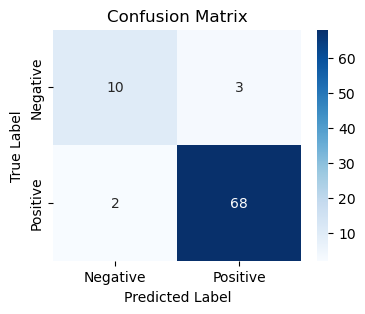

In [28]:
#Train logistic regression model: optimize feature selection
#features for training
feature_list = ["allergy", "alcohol_consuming",  
                "swallowing_difficulty", "yellow_fingers", 
                  "wheezing", "fatigue", "age_group_ages 45-59"] 

features_train_log = features_train_ohe.loc[:,feature_list]
model_log = LogisticRegression(solver = "lbfgs", max_iter=1000, C=4, random_state=42) 
model_log.fit(features_train_log, target_train)

#Crossvalidation to for more reliable estimate of model's performance
cv_logrreg = cross_val_score(model_log, features_train_log, target_train, scoring="accuracy", cv=5)
print("CrossValScore: " ,cv_logrreg.mean())

#Testdataset with selected features
features_test_log = features_test_ohe.loc[:,feature_list]
#Evaluate regression model
eval_regression(model_log, features_test_log, target_test)


## Final Results

### Analyzing Key Symptoms 

In the quest to differentiate between cancer and non-cancer cases, I identified several key symptomatologies that significantly influence our model's performance. These symptoms not only highlight the potential presence of cancer but also provide insight into lifestyle factors and other health conditions. Let's delve into the most important symptoms and their implications:

- Swallowing Difficulty:
Difficulty swallowing can be a significant indicator, especially for cancers like laryngeal cancer, which is associated with smoking. Smoking is a well-known risk factor for various types of cancer, including those affecting the throat, which can lead to swallowing problems.

- Yellow Fingers:
Yellowing of the fingers is often seen after prolonged smoking periods. This symptom serves as an indirect measure of the duration of smoking, a major risk factor for lung cancer.

- Alcohol Consumption:
Both smoking and alcohol consumption are parts of an unhealthy lifestyle that increases cancer risk. The combination of smoking and alcohol consumption significantly heightens the risk of developing cancer.

- Allergy:
There is interest in exploring whether smoking promotes allergies. Understanding this relationship can help in identifying how lifestyle choices impact overall health and cancer risk.

- Wheezing:
Wheezing was more prevalent in the non-cancer group. This suggests that the control group might not be entirely healthy but may include individuals with respiratory complaints seeking medical attention.

- Fatigue:
Fatigue was also more common in the non-cancer group. Similar to wheezing, this indicates that the control group might include individuals experiencing health issues, leading them to hospitals.

**Age Distribution Insights**

Our dataset revealed an uneven age distribution, which has implications for our analysis and model performance:

    Under 45: Only 3 individuals were in this age group.
    75 and above: This group included only 16 individuals.
    Age Group 45-59: This group was more frequently represented in the non-cancer cases.

Speculation on Age and Cancer Diagnosis

    The age group 45-59 being more common in non-cancer cases could be coincidental or could reflect certain lifestyle or environmental factors prevalent in this age group.
    Most lung cancer diagnoses occur around the age of 65, aligning with broader medical data suggesting that the risk of lung cancer increases significantly with age.
Reference: Lung Cancer Diagnosis and Treatment - MediClin